<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Convolutions/torch_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import display, clear_output

In [2]:
!pip install -q --upgrade wandb
clear_output()

In [3]:
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import wandb

from matplotlib import pyplot as plt
from torch.nn import functional as Functional
from torchvision import datasets
from tqdm import *

In [4]:
%matplotlib inline

In [15]:
WNB_FLAG = True
API_KEY = ''
WNB_PROJECT = 'torch_mnist'
WNB_LOGIN = 'dimildizio'

In [43]:
TRAIN_BATCH = 64
TEST_BATCH = 512  
N_IN = 256
N_OUT = 10
LR = 0.0001
NUM_WORKERS = 2
N_EPOCHS = 5
SEED = 42
MNISTF_MEAN = 0.2859
MNISTF_STD = 0.3530
PARAM_DICT = {'epochs':N_EPOCHS, 'train_batch':TRAIN_BATCH, 'num_workers':NUM_WORKERS, 
              'lr':LR, 'seed':SEED, 'classes':N_OUT}

In [7]:
def seed_all(seed):
  random.seed(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

seed_all(SEED)

In [8]:
transform = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(MNISTF_MEAN, MNISTF_STD)
                      ])

In [9]:
train_data = datasets.MNIST(root='./data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False,
                                  download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = TRAIN_BATCH, 
                                         num_workers = NUM_WORKERS, pin_memory = True,
                                         shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = TEST_BATCH, 
                                         num_workers = NUM_WORKERS, pin_memory = True,
                                         shuffle = False)

In [10]:
print('Train:', train_loader.dataset.train_data.shape)
print('Test:', test_loader.dataset.train_data.shape)

Train: torch.Size([60000, 28, 28])
Test: torch.Size([10000, 28, 28])


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [23]:
img=train_loader.dataset.train_data[1].numpy()

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


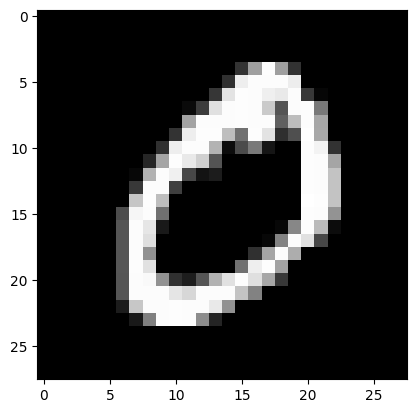

In [26]:
plt.imshow(img, cmap = 'gray')
plt.show()

In [53]:
for data in train_loader:
    print(len(data))
    print('Images:',data[0].shape)
    print('Labels:', data[1].shape)
    break
print(len(train_loader))

2
Images: torch.Size([64, 1, 28, 28])
Labels: torch.Size([64])
938


In [29]:
class MyConv(nn.Module):
  def __init__(self):
    super(MyConv, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(N_IN, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, N_OUT)

  def convolution(self, conv, x):
    convd = conv(x)
    activated = Functional.relu(convd)
    pooled = self.pool(activated)
    return pooled

  def fcs(self, x):
    layerd = self.fc1(x)
    activated = Functional.relu(layerd)
    layerd = self.fc2(activated)
    activated = Functional.relu(layerd)
    result = self.fc3(activated)
    return result

  def forward(self, x):
    x = self.convolution(self.conv1, x)
    x = self.convolution(self.conv2, x)
    #print('Convs output size:',x.shape)
    #view(-1, 64, 16*4*4)
    x = self.flatten(x)
    #use all mlps
    x = self.fcs(x)
    return x

In [84]:
net = MyConv()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=LR)

In [85]:
for epoch in tqdm_notebook(range(N_EPOCHS)):
  print('EPOCH:', epoch)
  for num, batch in enumerate(tqdm_notebook(train_loader)):
    loss_per_batch = 0.0
    optimizer.zero_grad()
    batch_X, batch_y = batch

    pred_y = net(batch_X)
    batch_loss = loss(pred_y, batch_y)
    batch_loss.backward()
    optimizer.step()

    loss_per_batch += batch_loss.item()
    if not num % 100:
      print(f'batch: {num}\nloss: {loss_per_batch}')
      loss_per_batch = 0.0
print('Finished training')

<ipython-input-85-18ea5c0349e5>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(N_EPOCHS)):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-85-18ea5c0349e5>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num, batch in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 1
batch: 0
loss: 2.291510820388794
epoch: 1
batch: 100
loss: 2.0128512382507324
epoch: 1
batch: 200
loss: 1.169163703918457
epoch: 1
batch: 300
loss: 0.6375989317893982
epoch: 1
batch: 400
loss: 0.48248180747032166
epoch: 1
batch: 500
loss: 0.43108394742012024
epoch: 1
batch: 600
loss: 0.5769839286804199
epoch: 1
batch: 700
loss: 0.5034728646278381
epoch: 1
batch: 800
loss: 0.2591336667537689
epoch: 1
batch: 900
loss: 0.2294209897518158


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 2
batch: 0
loss: 0.18924416601657867
epoch: 2
batch: 100
loss: 0.3479055166244507
epoch: 2
batch: 200
loss: 0.30004894733428955
epoch: 2
batch: 300
loss: 0.33040687441825867
epoch: 2
batch: 400
loss: 0.11989401280879974
epoch: 2
batch: 500
loss: 0.27845335006713867
epoch: 2
batch: 600
loss: 0.18665289878845215
epoch: 2
batch: 700
loss: 0.11251196265220642
epoch: 2
batch: 800
loss: 0.2735690772533417
epoch: 2
batch: 900
loss: 0.09368053823709488


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 3
batch: 0
loss: 0.13343305885791779
epoch: 3
batch: 100
loss: 0.1876557469367981
epoch: 3
batch: 200
loss: 0.15856730937957764
epoch: 3
batch: 300
loss: 0.19436100125312805
epoch: 3
batch: 400
loss: 0.22712582349777222
epoch: 3
batch: 500
loss: 0.15838438272476196
epoch: 3
batch: 600
loss: 0.12935204803943634
epoch: 3
batch: 700
loss: 0.12153644859790802
epoch: 3
batch: 800
loss: 0.15720295906066895
epoch: 3
batch: 900
loss: 0.04600249603390694


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 4
batch: 0
loss: 0.1724843829870224
epoch: 4
batch: 100
loss: 0.15030156075954437
epoch: 4
batch: 200
loss: 0.14412632584571838
epoch: 4
batch: 300
loss: 0.05432523787021637
epoch: 4
batch: 400
loss: 0.09849279373884201
epoch: 4
batch: 500
loss: 0.12009087204933167
epoch: 4
batch: 600
loss: 0.07360616326332092
epoch: 4
batch: 700
loss: 0.06056045740842819
epoch: 4
batch: 800
loss: 0.06781052052974701
epoch: 4
batch: 900
loss: 0.41728857159614563


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 5
batch: 0
loss: 0.09537158906459808
epoch: 5
batch: 100
loss: 0.11954659223556519
epoch: 5
batch: 200
loss: 0.06261848658323288
epoch: 5
batch: 300
loss: 0.1064235046505928
epoch: 5
batch: 400
loss: 0.047518543899059296
epoch: 5
batch: 500
loss: 0.08213479816913605
epoch: 5
batch: 600
loss: 0.05331205204129219
epoch: 5
batch: 700
loss: 0.05857902765274048
epoch: 5
batch: 800
loss: 0.06288308650255203
epoch: 5
batch: 900
loss: 0.041397616267204285


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 6
batch: 0
loss: 0.0875004231929779
epoch: 6
batch: 100
loss: 0.09445980936288834
epoch: 6
batch: 200
loss: 0.014807293191552162
epoch: 6
batch: 300
loss: 0.16210219264030457
epoch: 6
batch: 400
loss: 0.07663556188344955
epoch: 6
batch: 500
loss: 0.018327822908759117
epoch: 6
batch: 600
loss: 0.039265163242816925
epoch: 6
batch: 700
loss: 0.033341944217681885
epoch: 6
batch: 800
loss: 0.06647082418203354
epoch: 6
batch: 900
loss: 0.03943196311593056


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 7
batch: 0
loss: 0.12303455919027328
epoch: 7
batch: 100
loss: 0.17339813709259033
epoch: 7
batch: 200
loss: 0.06655784696340561
epoch: 7
batch: 300
loss: 0.06401974707841873
epoch: 7
batch: 400
loss: 0.029443738982081413
epoch: 7
batch: 500
loss: 0.1411018818616867
epoch: 7
batch: 600
loss: 0.03833826258778572
epoch: 7
batch: 700
loss: 0.10528842359781265
epoch: 7
batch: 800
loss: 0.0350833460688591
epoch: 7
batch: 900
loss: 0.045641619712114334


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 8
batch: 0
loss: 0.1731562614440918
epoch: 8
batch: 100
loss: 0.1499999463558197
epoch: 8
batch: 200
loss: 0.08124320954084396
epoch: 8
batch: 300
loss: 0.11324251443147659
epoch: 8
batch: 400
loss: 0.015762217342853546
epoch: 8
batch: 500
loss: 0.17717279493808746
epoch: 8
batch: 600
loss: 0.0063411882147192955
epoch: 8
batch: 700
loss: 0.23208844661712646
epoch: 8
batch: 800
loss: 0.06842228770256042
epoch: 8
batch: 900
loss: 0.026163388043642044


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 9
batch: 0
loss: 0.09733771532773972
epoch: 9
batch: 100
loss: 0.006137673277407885
epoch: 9
batch: 200
loss: 0.0215893667191267
epoch: 9
batch: 300
loss: 0.043212663382291794
epoch: 9
batch: 400
loss: 0.1365765482187271
epoch: 9
batch: 500
loss: 0.02418246865272522
epoch: 9
batch: 600
loss: 0.03582893684506416
epoch: 9
batch: 700
loss: 0.07038719952106476
epoch: 9
batch: 800
loss: 0.06121549755334854
epoch: 9
batch: 900
loss: 0.1469307541847229


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 10
batch: 0
loss: 0.009353773668408394
epoch: 10
batch: 100
loss: 0.015413070097565651
epoch: 10
batch: 200
loss: 0.09341853111982346
epoch: 10
batch: 300
loss: 0.050455644726753235
epoch: 10
batch: 400
loss: 0.029135948047041893
epoch: 10
batch: 500
loss: 0.017789896577596664
epoch: 10
batch: 600
loss: 0.012873077765107155
epoch: 10
batch: 700
loss: 0.1439206749200821
epoch: 10
batch: 800
loss: 0.04221493378281593
epoch: 10
batch: 900
loss: 0.044689785689115524
Finished training


In [11]:
classes = tuple(str(i) for i in range(10))
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

In [87]:
with torch.no_grad():
  for data in test_loader:
    images, labels = data
    pred_y = net(images)
    maxval, pred_labels = torch.max(pred_y, 1)
    mask = (pred_labels == labels).squeeze()
    for i in range(10):
      label = labels[i]
      class_correct[label] += mask[i].item()
      class_total[label] +=1

for i in range(10):
    print(f'Accuracy of {classes[i]}: {round(100 * (class_correct[i]/class_total[i]),2)}%') 

Accuracy of 0: 100.0%
Accuracy of 1: 95.24%
Accuracy of 2: 100.0%
Accuracy of 3: 100.0%
Accuracy of 4: 100.0%
Accuracy of 5: 92.86%
Accuracy of 6: 100.0%
Accuracy of 7: 100.0%
Accuracy of 8: 100.0%
Accuracy of 9: 100.0%


New let's gether it all together

In [53]:
class ModelRunner:
  def __init__(self, lr = LR, epochs = N_EPOCHS):
    self.traindata = train_loader
    self.testdata = test_loader

    self.lr = LR
    self.epochs = epochs
    
    self.model = MyConv()
    self.loss = nn.CrossEntropyLoss()
    
    self.optimizer = torch.optim.ASGD(self.model.parameters())#, lr=lr)
    self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma = 0.9)

  def get_correct_score(self, pred_ys, target):
    pred_p = pred_ys.argmax(dim=1, keepdim=True)
    correct_mask = pred_p.eq(target.view_as(pred_p))
    return correct_mask.sum().item()

  def print_n_log(self, correct, iloss, mode = 'Train'):
    myset = self.traindata if mode == 'Train' else self.testdata
    predicted = correct / len(myset.dataset)
    tqdm.write(f'\nMode: {mode}\nAvgLoss: {iloss}\nAccuracy:{round(predicted, 2)}%\n')
    if WNB_FLAG:
      wandb.log({mode+'_loss':iloss, mode+'_accuracy':predicted})

  def predict(self, data, target):
    preds = self.model(data)
    myloss = self.loss(preds, target)
    score = self.get_correct_score(preds, target)
    return preds, myloss, score

  def train(self): 
    print('training')
    correct = 0
    self.model.train()
    for _batch_idx, (data, target) in tqdm(enumerate(self.traindata), total=len(self.traindata)):
      self.optimizer.zero_grad()

      preds, train_loss, score = self.predict(data, target)
      correct+=score

      train_loss.backward()
      self.optimizer.step()

    self.print_n_log(correct, train_loss)
    self.scheduler.step()

  def test(self):
    correct = 0
    self.model.eval()
    with torch.no_grad():
      for data, target in self.testdata:
        preds, test_loss, score = self.predict(data, target)
        correct += score
    self.print_n_log(correct, test_loss, 'Test')

  def run_loop(self):
    print('Total Epochs:', self.epochs)
    for epoch in range(self.epochs):
      print('Epoch:', epoch+1)
      self.train()
      self.test()

In [13]:
def log_wnb(model):
  if WNB_FLAG:
    os.environ["WANDB_API_KEY"] = API_KEY
    wandb.init(project=WNB_PROJECT, entity=WNB_LOGIN, reinit=True, config=PARAM_DICT)
    wandb.watch(model, log='all')

In [16]:
def mainloop():
  seed_all(SEED)
  runner = ModelRunner()
  log_wnb(runner.model)
  runner.run_loop()

In [33]:
WNB_FLAG=True

In [54]:
mainloop()

Total Epochs: 5
Epoch: 1
training


100%|██████████| 938/938 [00:26<00:00, 34.80it/s]



Mode: Train
AvgLoss: 0.34258565306663513
Accuracy:0.61%


Mode: Test
AvgLoss: 0.5726615190505981
Accuracy:0.87%

Epoch: 2
training


100%|██████████| 938/938 [00:27<00:00, 34.39it/s]


Mode: Train
AvgLoss: 0.12042106688022614
Accuracy:0.92%




Mode: Test
AvgLoss: 0.305523157119751
Accuracy:0.95%

Epoch: 3
training


100%|██████████| 938/938 [00:26<00:00, 34.94it/s]


Mode: Train
AvgLoss: 0.2466856986284256
Accuracy:0.95%




Mode: Test
AvgLoss: 0.31311681866645813
Accuracy:0.95%

Epoch: 4
training


100%|██████████| 938/938 [00:26<00:00, 34.85it/s]


Mode: Train
AvgLoss: 0.13934099674224854
Accuracy:0.96%




Mode: Test
AvgLoss: 0.19534742832183838
Accuracy:0.97%

Epoch: 5
training


100%|██████████| 938/938 [00:27<00:00, 34.31it/s]


Mode: Train
AvgLoss: 0.02228557877242565
Accuracy:0.97%




Mode: Test
AvgLoss: 0.18659523129463196
Accuracy:0.97%

